In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [215]:
# Name of the file we want to read. 
# Remember, "Measurement.ttbin" files read all the files in sequence 'Measurement'

# file = 'C:/Users/HP/Downloads/TimeTags_RaulAir_2024-10-25_172331.ttbin' #QD_4_WF
# file = 'C:/Users/HP/Downloads/TimeTags_RaulAir_2024-10-25_180501.ttbin' #QD_4_NoF
# file = 'C:/Users/HP/Downloads/TimeTagsRaul_2024-10-31_162547.ttbin' #QD_5
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_125402.ttbin' #QD_6
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_142905.ttbin' #QD_7
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_150423.ttbin' #QD_8
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_152250.ttbin' #QD_9
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_154530.ttbin' #QD_10
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_161338.ttbin' #QD_11
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_162838.ttbin' #QD_12
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_171943.ttbin' #QD_13
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-08_173951.ttbin' #QD_14
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_113540.ttbin' #QD_15
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_124110.ttbin' #QD_16
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_125626.ttbin' #QD_17
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_143447.ttbin' #QD_18
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_145507.ttbin' #QD_19
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_150747.ttbin' #QD_20
# file = 'C:/Users/HP/Downloads/TimeTags_2024-11-11_153048.ttbin' #QD_21

file = 'C:/Users/HP/Downloads/TimeTags_2024-11-13_143436.ttbin' #QD_28

In [216]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
fr = FileReader(file)
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2024-11-13 14:34:36 +0100
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [217]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

# measure photon antibunching
ch1 = config['registered channels'][0] # first photon channel for antibunching measurements
ch2 = config['registered channels'][1] # second photon channel for antibunching measurements

cr = Countrate(virtual_tagger, [ch1, ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

print(f"Rate of counts channel {ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Rate of counts channel {ch2} (counts/sec) : {cr.getData()[1]}")

Rate of counts channel 1 (counts/sec) : 9767.120304324755
Rate of counts channel 2 (counts/sec) : 9447.247744755543


Save the data when the emission is above a certain treshold

In [227]:
fr = FileReader(file)
fr_copy = FileReader(file)

acc_list = []
n = 100
#treshold = 2*np.mean(cr.getData())*1e-12
treshold = 18000*1e-12
print("Treshold: ", treshold, "\n")
t_ant = 0

rates = np.array([])
times = np.array([])

IniInterval = abs(fr_copy.getData(1).getTimestamps())
EndInterval = 0

intervals_ON = np.array([])
ini_interval_ON = 0
end_interval_ON = 0
intervals_OFF = np.array([])
ini_interval_OFF = 0
end_interval_OFF = 0

not_saved = 0
saved = 0
flag_ON = 0
flag_OFF = 0

while (fr.hasData()):
    data = fr.getData(n)
    data_copy = fr_copy.getData(n)
    
    ts = data.getTimestamps()
    ts_copy = data_copy.getTimestamps()
    ch = data.getChannels()
    
    #EndInterval = (abs(ts[-1] + ts_copy[0]))/2
    EndInterval = (abs(ts[-1] + ts_copy[-1]))/2
    if EndInterval == IniInterval:
        break
    
    data_raw = np.array([ch, ts])
    
    # Restructure into columns (one for each channel)
    data_ch1 = data_raw[1, np.where(data_raw[0,:] == ch1)].copy() # Canal 1
    data_ch2 = data_raw[1, np.where(data_raw[0,:] == ch2)].copy() # Canal 2
    
    # Creating an empty array the size of the largest dataset
    data_ch = np.zeros([2, max(data_ch1.shape[1], data_ch2.shape[1])])
    
    # Filling the channel columns with the respective data (one of them will always fall short)
    data_ch[0, :data_ch1.shape[1]] += data_ch1[0]
    data_ch[1, :data_ch2.shape[1]] += data_ch2[0]
    
    # Check we get all data
    #print(data_ch1.size, data_ch2.size, data_ch1.size+data_ch2.size)
    
    delta_t = abs(IniInterval - EndInterval)
    rate = n / delta_t
    
    times = np.append(times, abs(IniInterval + EndInterval)/2)
    rates = np.append(rates,rate)
    
    if (rate > treshold):
        acc_list.append(data_ch - t_ant)
        saved += 1
        
        if(flag_ON == 0):
            #Beginning ON interval
            ini_interval_ON = IniInterval
            flag_ON = 1
        if(flag_OFF == 1):
            #End OFF interval
            end_interval_OFF = IniInterval
            intervals_OFF = np.append(intervals_OFF, abs(end_interval_OFF - ini_interval_OFF))
            flag_OFF = 0
            
    else:
        t_ant += delta_t
        not_saved += 1

        if(flag_ON == 1):
            #End ON interval
            end_interval_ON = IniInterval
            intervals_ON = np.append(intervals_ON, abs(end_interval_ON - ini_interval_ON))
            flag_ON = 0
            
        if(flag_OFF == 0):
            #Beginning OFF interval
            ini_interval_OFF = IniInterval
            flag_OFF = 1
            
    IniInterval = EndInterval

if(flag_ON == 1):
    #End of last ON interval
    end_interval_ON = IniInterval
    intervals_ON = np.append(intervals_ON, abs(end_interval_ON - ini_interval_ON))
if(flag_OFF == 1):
    #End of last OFF interval
    end_interval_OFF = IniInterval
    intervals_OFF = np.append(intervals_OFF, abs(end_interval_OFF - ini_interval_OFF))
    flag_OFF = 0

print("Saved: ", saved)
print("Not Saved: ", not_saved)

Treshold:  1.8e-08 

Saved:  87688
Not Saved:  29888


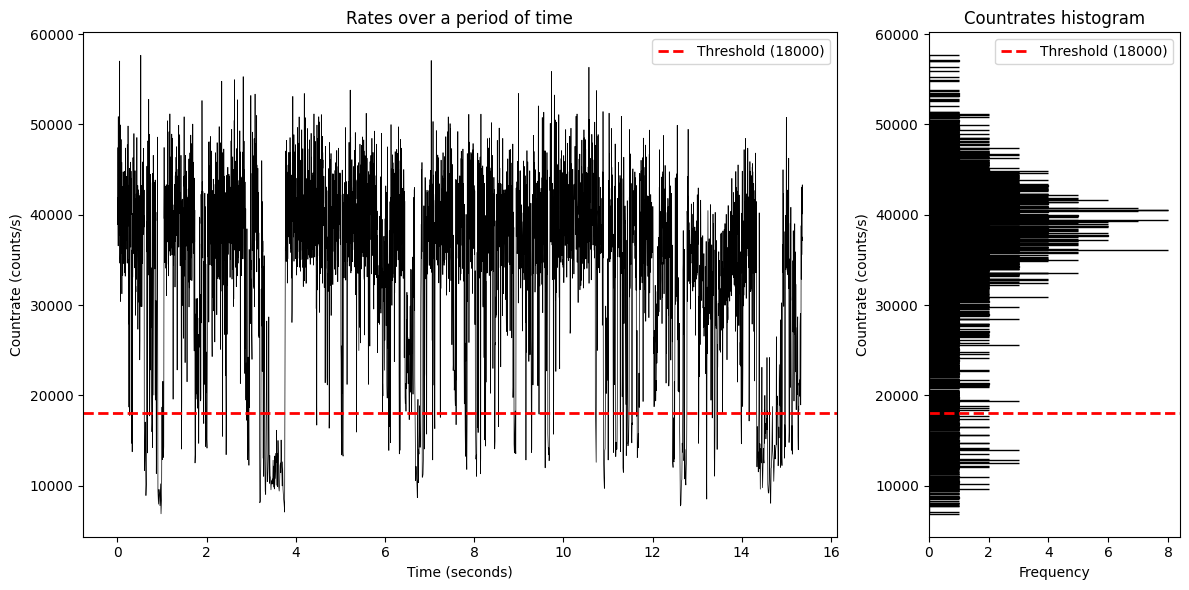

In [228]:
rates_hist = np.array(rates) * 1e12 #Pasamos la count-rate a counts/s
times_hist = np.array(times - times[0]) * 1e-12 #Pasamos los tiempos a segundos

# Indices a representar
ini_index = 0
end_index = 5000

# Parámetros del histograma
num_bins = 10000
min_value = np.min(rates_hist[ini_index:end_index])
max_value = np.max(rates_hist[ini_index:end_index])

# Crear la figura y los subplots
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6))

# Gráfica de línea en el eje izquierdo
ax_scatter.plot(times_hist[ini_index:end_index], rates_hist[ini_index:end_index], color='black', linewidth=0.5)  # Línea fina negra conectando puntos
ax_scatter.axhline(y=treshold * 1e12, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e12:.0f})')
ax_scatter.set_xlabel('Time (seconds)')
ax_scatter.set_ylabel('Countrate (counts/s)')
ax_scatter.set_title('Rates over a period of time')
ax_scatter.legend()

# Histograma en el eje derecho, rotado 90 grados
ax_hist.hist(rates_hist[ini_index:end_index], bins=num_bins, range=(min_value, max_value), color='blue', edgecolor='black', orientation='horizontal')
ax_hist.axhline(y=treshold * 1e12, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e12:.0f})')
ax_hist.set_xlabel('Frequency')
ax_hist.set_ylabel('Countrate (counts/s)')
ax_hist.set_title('Countrates histogram')
ax_hist.legend()

# Ajustar el layout para que no se solapen
plt.tight_layout()
plt.show()

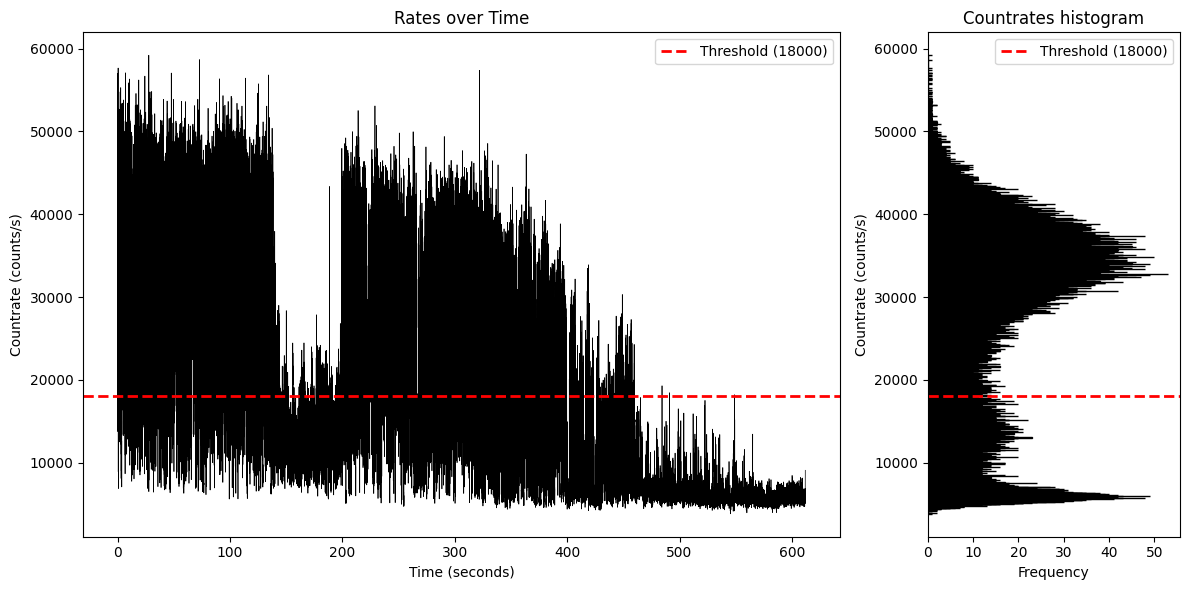

Tiempo total de medida:  611.9086125101439 segundos
Tiempo total: 0 horas, 10 minutos, 11 segundos
Time intervals ON:  274.867324258032
Time intervals ON:  337.047851829856
Time intervals ON + OFF:  611.915176087888


In [229]:
rates_hist = np.array(rates) * 1e12 #Pasamos la count-rate a counts/s
times_hist = np.array(times - times[0]) * 1e-12#Pasamos los tiempos a segundos

# Parámetros del histograma
num_bins = 10000
min_value = np.min(rates_hist)
max_value = np.max(rates_hist)

# Crear la figura y los subplots
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6))

# Gráfica de línea en el eje izquierdo
ax_scatter.plot(times_hist, rates_hist, color='black', linewidth=0.5)  # Línea fina negra conectando puntos
ax_scatter.axhline(y=treshold * 1e12, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e12:.0f})')
ax_scatter.set_xlabel('Time (seconds)')
ax_scatter.set_ylabel('Countrate (counts/s)')
ax_scatter.set_title('Rates over Time')
ax_scatter.legend()

# Histograma en el eje derecho, rotado 90 grados
ax_hist.hist(rates_hist, bins=num_bins, range=(min_value, max_value), color='blue', edgecolor='black', orientation='horizontal')
ax_hist.axhline(y=treshold * 1e12, color='red', linestyle='--', linewidth=2, label=f'Threshold ({treshold * 1e12:.0f})')
ax_hist.set_xlabel('Frequency')
ax_hist.set_ylabel('Countrate (counts/s)')
ax_hist.set_title('Countrates histogram')
ax_hist.legend()

# Ajustar el layout para que no se solapen
plt.tight_layout()
plt.show()


total_seconds = times_hist[-1] - times_hist[0]
# Convertir a horas, minutos y segundos
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

# Imprimir el resultado en el formato solicitado
print("Tiempo total de medida: ", total_seconds, "segundos")
print(f"Tiempo total: {int(hours)} horas, {int(minutes)} minutos, {int(seconds)} segundos")
print("Time intervals ON: ", np.sum(intervals_ON)*1e-12)
print("Time intervals ON: ", np.sum(intervals_OFF)*1e-12)
print("Time intervals ON + OFF: ", (np.sum(intervals_ON) + np.sum(intervals_OFF))*1e-12)

In [230]:
print(max(intervals_OFF)*1e-12)
print(total_seconds - (np.sum(intervals_ON) + np.sum(intervals_OFF))*1e-12)

print(intervals_OFF[-1]*1e-12)
print(intervals_OFF[-2]*1e-12)

62.86110936944
-0.006563577744032045
62.86110936944
58.053388931183996


Exponential Decay Fit Parameters:
A = 2216.180 ± 58.986
tau_0 = 0.0097 ± 0.0003 seconds 

Power Law Fit Parameters:
a = 2.476 ± 0.113
alpha = 0.2073 ± 0.0093


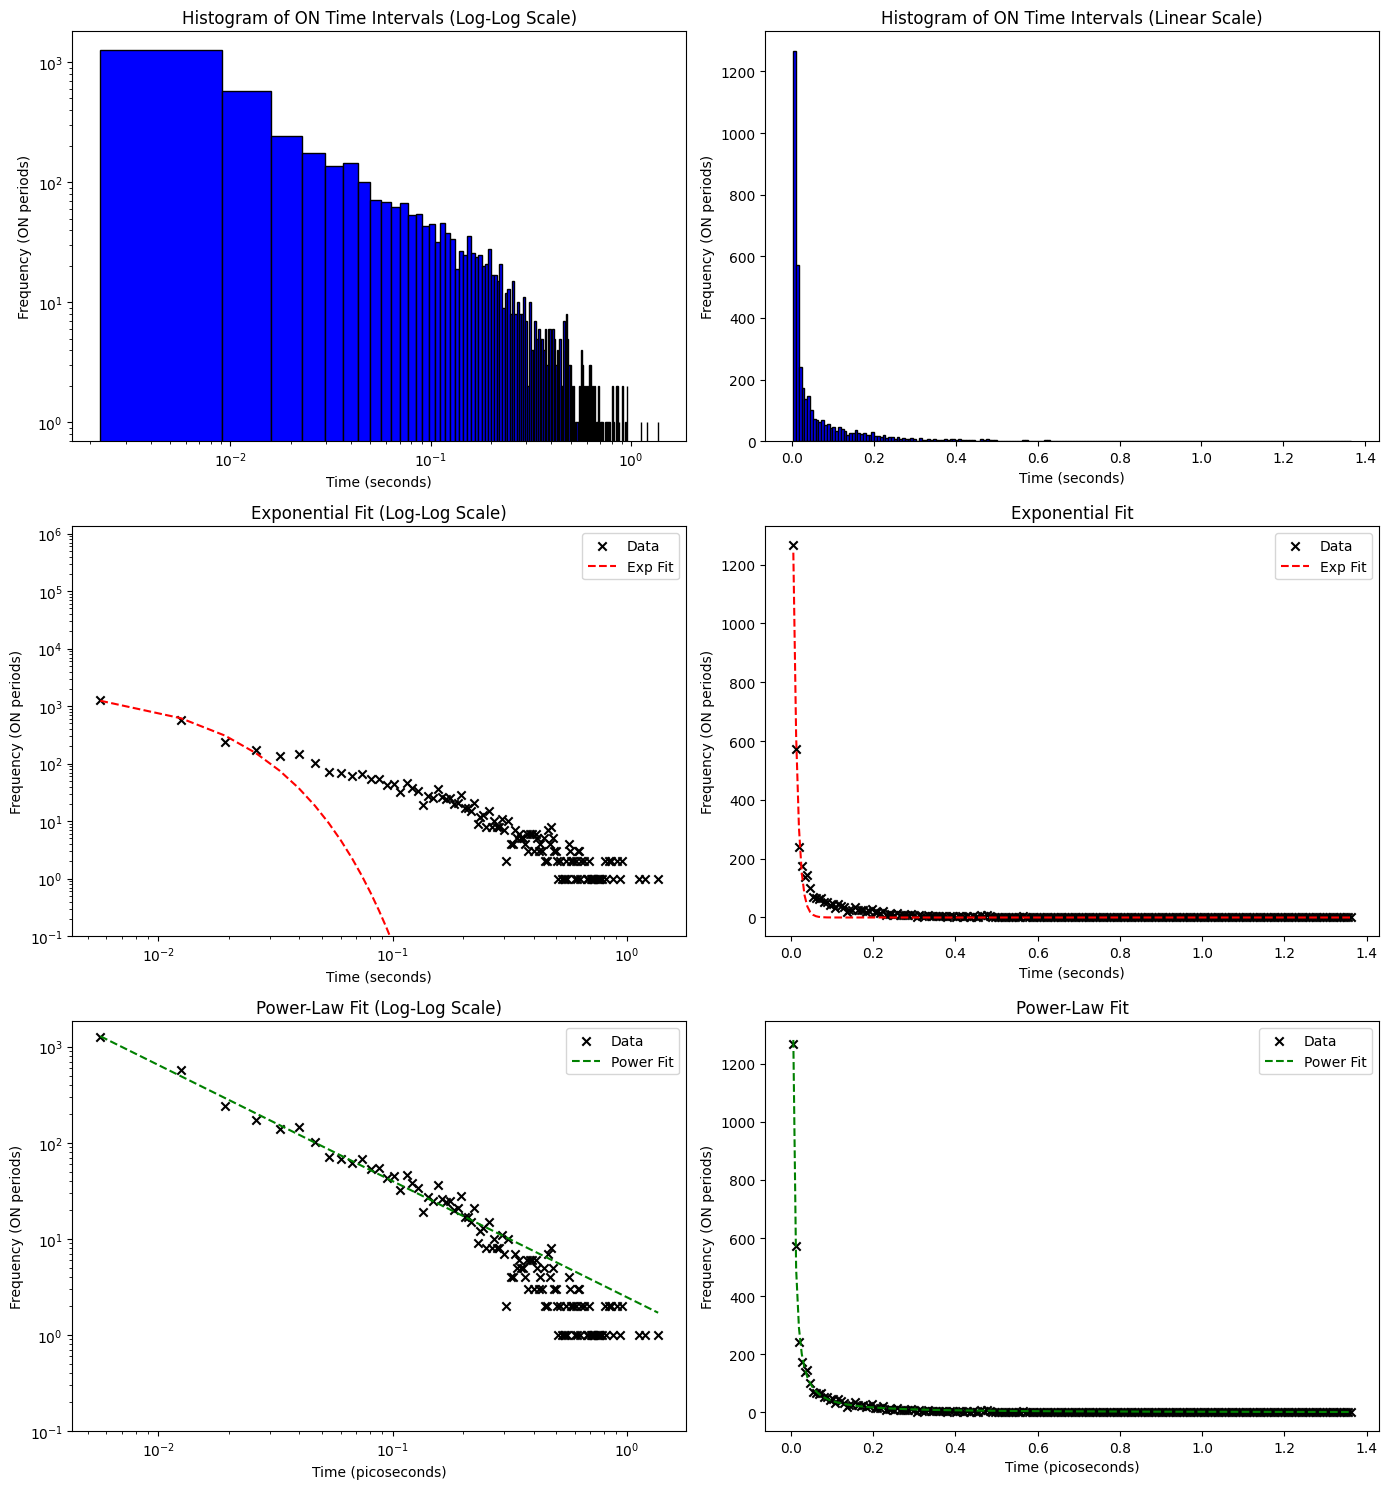

In [231]:
# Define parameters
n_bin_interval = 200
intervals_ON_sec = intervals_ON
intervals_ON_sec = intervals_ON * 1e-12 # Tenemos el tiempo en segundos
min_val = np.min(intervals_ON_sec)
max_val = np.max(intervals_ON_sec)

# Calculate histogram data for fitting
counts, bin_edges = np.histogram(intervals_ON_sec, bins=n_bin_interval, range=(min_val, max_val))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ---- Define fit functions ----
def exponential_decay(tau, A, tau_0):
    return A * np.exp(-tau / tau_0)

def power_law(tau, a, alpha):
    return a * tau ** (-1 - alpha)

# ---- Perform fits ----
# Initial parameter guesses
exp_initial_guess = [max(counts), 1]
power_initial_guess = [max(counts), 1]

# Fit exponential decay
exp_params, exp_covariance = curve_fit(exponential_decay, bin_centers, counts, p0=exp_initial_guess)
exp_errors = np.sqrt(np.diag(exp_covariance))  # Errors are the square root of the diagonal of the covariance matrix

# Fit power law
power_params, power_covariance = curve_fit(power_law, bin_centers, counts, p0=power_initial_guess)
power_errors = np.sqrt(np.diag(power_covariance))

# ---- Print parameters and errors ----
print("Exponential Decay Fit Parameters:")
print(f"A = {exp_params[0]:.3f} ± {exp_errors[0]:.3f}")
print(f"tau_0 = {exp_params[1]:.4f} ± {exp_errors[1]:.4f} seconds \n")
print("Power Law Fit Parameters:")
print(f"a = {power_params[0]:.3f} ± {power_errors[0]:.3f}")
print(f"alpha = {power_params[1]:.4f} ± {power_errors[1]:.4f}")

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 15))

# ---- Original Histogram ----
# Plot histogram with logarithmic scale
axs[0, 0].hist(intervals_ON_sec, bins=n_bin_interval, range=(min_val, max_val), color='blue', edgecolor='black')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel("Time (seconds)")
axs[0, 0].set_ylabel("Frequency (ON periods)")
axs[0, 0].set_title("Histogram of ON Time Intervals (Log-Log Scale)")

# Plot histogram with linear scale
axs[0, 1].hist(intervals_ON_sec, bins=n_bin_interval, range=(min_val, max_val), color='blue', edgecolor='black')
axs[0, 1].set_xlabel("Time (seconds)")
axs[0, 1].set_ylabel("Frequency (ON periods)")
axs[0, 1].set_title("Histogram of ON Time Intervals (Linear Scale)")

# ---- Scatter Plot of Binned Frequencies with Fits ----
# Plot scatter with log-log scale
axs[1, 0].scatter(bin_centers, counts, color='k', marker='x', label="Data")
axs[1, 0].plot(bin_centers, exponential_decay(bin_centers, *exp_params), color='red', linestyle='--', label="Exp Fit")
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylim(bottom=1e-1)
axs[1, 0].set_xlabel("Time (seconds)")
axs[1, 0].set_ylabel("Frequency (ON periods)")
axs[1, 0].set_title("Exponential Fit (Log-Log Scale)")
axs[1, 0].legend()

# Plot scatter with linear scale
axs[1, 1].scatter(bin_centers, counts, color='k', marker='x', label="Data")
axs[1, 1].plot(bin_centers, exponential_decay(bin_centers, *exp_params), color='red', linestyle='--', label="Exp Fit")
axs[1, 1].set_xlabel("Time (seconds)")
axs[1, 1].set_ylabel("Frequency (ON periods)")
axs[1, 1].set_title("Exponential Fit")
axs[1, 1].legend()

# ---- Individual Fit Plots ----
# Power-Law fit in log scale
axs[2, 0].scatter(bin_centers, counts, color='k', marker='x', label="Data")
axs[2, 0].plot(bin_centers, power_law(bin_centers, *power_params), color='green', linestyle='--', label="Power Fit")
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
axs[2, 0].set_ylim(bottom=1e-1)
axs[2, 0].set_xlabel("Time (picoseconds)")
axs[2, 0].set_ylabel("Frequency (ON periods)")
axs[2, 0].set_title("Power-Law Fit (Log-Log Scale)")
axs[2, 0].legend()

# Power-law fit in log-log scale
axs[2, 1].scatter(bin_centers, counts, color='k', marker='x', label="Data")
axs[2, 1].plot(bin_centers, power_law(bin_centers, *power_params), color='green', linestyle='--', label="Power Fit")
axs[2, 1].set_xlabel("Time (picoseconds)")
axs[2, 1].set_ylabel("Frequency (ON periods)")
axs[2, 1].set_title("Power-Law Fit")
axs[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [232]:
# Calculate the fitted values
exp_fit_values = exponential_decay(bin_centers, *exp_params)
power_fit_values = power_law(bin_centers, *power_params)

# Calculate Sum of Squared Residuals (SSR)
ssr_exp = np.sum((counts - exp_fit_values) ** 2)
ssr_power = np.sum((counts - power_fit_values) ** 2)

# Calculate R² values
r_squared_exp = 1 - (ssr_exp / np.sum((counts - np.mean(counts)) ** 2))
r_squared_power = 1 - (ssr_power / np.sum((counts - np.mean(counts)) ** 2))

# Print results
print(f"Exponential Fit: SSR = {ssr_exp}, R² = {r_squared_exp}")
print(f"Power Law Fit: SSR = {ssr_power}, R² = {r_squared_power}")

# Determine which fit is better
if ssr_exp < ssr_power:
    print("The exponential fit is more accurate based on SSR.")
else:
    print("The power-law fit is more accurate based on SSR.")

if r_squared_exp > r_squared_power:
    print("The exponential fit is more accurate based on R².")
else:
    print("The power-law fit is more accurate based on R².")

Exponential Fit: SSR = 70340.47395452257, R² = 0.9654992933106974
Power Law Fit: SSR = 12971.178220383481, R² = 0.9936378760330012
The power-law fit is more accurate based on SSR.
The power-law fit is more accurate based on R².


Convert back into numpy array

In [233]:
total_len = sum(len(acc_list[i][0]) for i in range(len(acc_list)))
acc = np.zeros([total_len, 2])
index = 0

for i in range(len(acc_list)):
    for j in range(len(acc_list[i][0])):
        acc[index,:] = [acc_list[i][0][j], acc_list[i][1][j]]
        index += 1
        
df = pd.DataFrame(acc)

Plot the results using a certain bin and number of bins

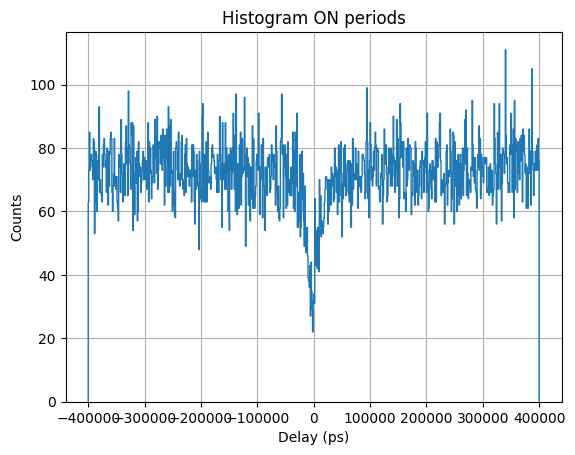

In [234]:
# Variables de entrada
bin_width = 1000      # Anchura del bin en picosegundos
nbin = 800          # Número total de bins

flag = 0
ini_t1 = 0

# Rango máximo de delays a considerar
max_delay = bin_width * nbin / 2

# Extrae los tiempos de llegada de cada canal, ignorando ceros
times_channel_0 = df[0].values
times_channel_1 = df[1].values

# Inicializa una lista para almacenar los delays
delay_matrix = []

# Iterar sobre eventos del canal 0, ignorando ceros
for t0 in times_channel_0:
    if t0 == 0:
        continue  # Saltar eventos en canal 0 que son ceros
    for n_t1, t1 in enumerate(times_channel_1[ini_t1:], start=ini_t1):
        if t1 == 0:
            continue  # Saltar eventos en canal 1 que son ceros
        
        delay = t0 - t1
        
        if max_delay > delay and flag == 0:
            flag = 1 # Hacemos esto ya que en un mismo rango podemos encontrar varios delays que cumplan la solucion
            ini_t1 = n_t1

        # Si el delay cae dentro del rango de bineado, guárdalo
        if -max_delay <= delay <= max_delay:
            delay_matrix.append(delay)
        # Si el delay supera el mínimo, termina la comparación con t1
        elif delay < -max_delay:
            flag = 0
            break

# Convierte la lista de delays a un array de Numpy para optimizar operaciones
delay_matrix = np.array(delay_matrix)

# Define los bins para el histograma
bins = np.arange(-max_delay, max_delay + bin_width, bin_width)


# Graficar el histograma de delays
plt.hist(delay_matrix, bins=bins, histtype='step')
plt.xlabel("Delay (ps)")
plt.ylabel("Counts")
plt.title("Histogram ON periods")
plt.grid(True)
plt.show()

In [235]:
print(np.max(times_channel_0))
print(np.max(times_channel_1))

print(np.min(times_channel_0))
print(np.min(times_channel_1))

7.900532318039435e+16
7.900532312530931e+16
-216133353529232.0
-274186742460416.0


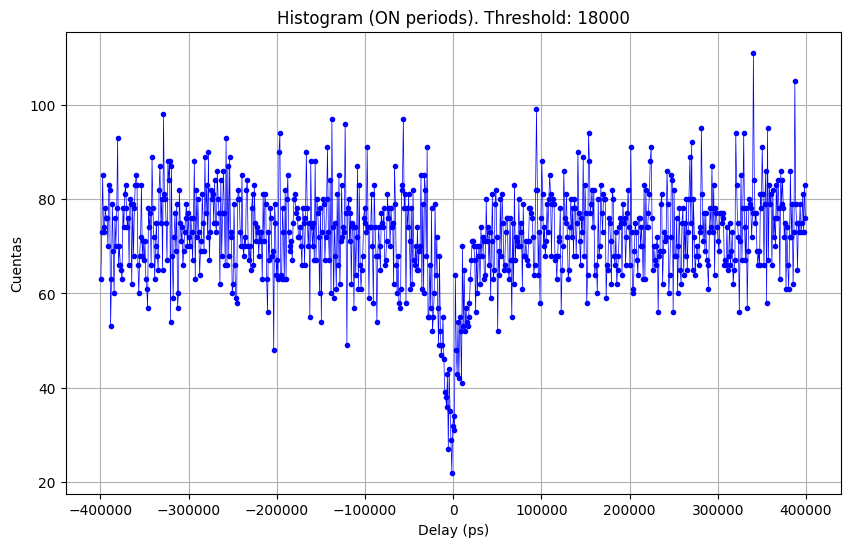

In [236]:
# Computa el histograma para obtener los conteos en cada bin
counts, bin_edges = np.histogram(delay_matrix, bins=bins)

# Define las posiciones en el eje x como el centro de cada bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Tamaño del gráfico (puedes ajustar figsize)
plt.figure(figsize=(10, 6))

# Graficar los conteos en cada bin como puntos conectados por líneas
plt.plot(bin_centers, counts, marker='o', color='blue', linestyle='-', linewidth=0.5, markersize=3)

# Etiquetas y título
plt.xlabel("Delay (ps)")
plt.ylabel("Cuentas")
plt.title(f'Histogram (ON periods). Threshold: {treshold * 1e12:.0f}')

# Habilitar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [237]:

# Define the fitting function: a * (1 - b * exp(abs(tau - t0) / tau0)
def fitting_function(tau, t_0, tau_0, a, b):
    return a * (1 - b * np.exp(-np.abs(tau - t_0) / tau_0))

# Function to normalize counts and fit the data
def fit_noblinking(tau, counts):
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=[0, 1e5, 1, 1])
    
    # Extract fitted parameters
    t_0, tau_0, a, b = popt
    
    # Calculate the standard deviations of the parameters
    perr = np.sqrt(np.diag(pcov))
    error_t0, error_tau0, error_a, error_b = perr

    # Print fitted parameters and their errors
    print(f"Fitted parameters:\n t₀ = {t_0:.3f} ± {error_t0:.3f} ps \n a = {a:.3f} ± {error_a:.3f} \n b = {b:.3f} ± {error_b:.3f}")
    print(f"Lifetime = {tau_0 / 1000:.2f} ± {error_tau0 / 1000:.2f} ns")
    
    # Calculate g²(τ = t₀)
    value_at_t_0 = fitting_function(t_0, t_0, tau_0, a, b)
    error_value_at_t_0 = np.sqrt(error_a**2 + error_b**2)  # Estimate error propagation
    print(f"g²(τ = t₀) = {value_at_t_0:.3f} ± {error_value_at_t_0:.3f}")
    
    return t_0, tau_0, a, b

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, t_0, tau_0, a, b, width=10, height=6):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, marker='o', linestyle='-', color='b', label='Normalized Data', markersize=3, linewidth=0.7)
    plt.title('Normalized auto-correlation graph')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function(tau_fine, t_0, tau_0, a, b)
    
    # Plot fitted curve
    plt.plot(tau_fine, fitted_curve, 'r-', label=f'Fit: t₀={t_0:.2f}ps, τ₀={tau_0:.2f}ps, g²(τ = t₀) = {a-b:.3f}')
    
    # Add title and labels
    plt.title('Normalized auto-correlation graph')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Normalized Counts')
    #plt.legend()
    plt.grid(True)
    plt.show()

In [238]:
# Define the fitting function: 1 - C * exp(abs(tau - t0) / tau0)
def fitting_function_blinking(tau, t_0, tau_0, p):
    return 1 - ((1-p)/p) * np.exp(-np.abs(tau - t_0) / tau_0)

# Function to normalize counts and fit the data
def fit_blinking(tau, counts):    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function_blinking, tau, counts, p0=[0, 1e5, 1])
    
    # Extract fitted parameters
    t_0, tau_0, p = popt
    
    # Calculate the standard deviations of the parameters
    perr = np.sqrt(np.diag(pcov))
    error_t0, error_tau0, error_p = perr

    # Print fitted parameters and their errors
    print(f"Fitted parameters: t₀ = {t_0:.2f} ± {error_t0:.2f} ps")
    print(f"Lifetime = {tau_0 / 1000:.2f} ± {error_tau0 / 1000:.2f} ns")
    print(f"p = {p:.2f} ± {error_p:.2f}")
    
    # Calculate g²(τ = t₀)
    value_at_t_0 = fitting_function_blinking(t_0, t_0, tau_0, p)
    error_value_at_t_0 = error_p/(p**2)  # Estimate error propagation
    print(f"g²(τ = t₀) = {value_at_t_0:.3f} ± {error_value_at_t_0:.3f}")
    
    return t_0, tau_0, p

# Function to plot the normalized data and the fitted curve
def plot_fit_blinking(tau, counts, t_0, tau_0, p, width=10, height=6):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, marker='o', linestyle='-', color='b', label='Normalized Data', markersize=3, linewidth=0.7)
    plt.title('Normalized auto-correlation graph')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function_blinking(tau_fine, t_0, tau_0, p)
    
    # Plot fitted curve
    value_at_t_0 = fitting_function_blinking(t_0, t_0, tau_0, p)
    plt.plot(tau_fine, fitted_curve, 'r-', label=f'Fit: t₀={t_0:.2f}ps, τ₀={tau_0:.2f}ps, g²(τ = t₀) = {value_at_t_0:.3f}')
    
    # Add title and labels
    plt.title('Normalized auto-correlation graph')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Normalized Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

Fitted parameters:
 t₀ = -2103.109 ± 700.358 ps 
 a = 0.897 ± 0.004 
 b = 0.622 ± 0.044
Lifetime = 14.15 ± 1.46 ns
g²(τ = t₀) = 0.339 ± 0.044


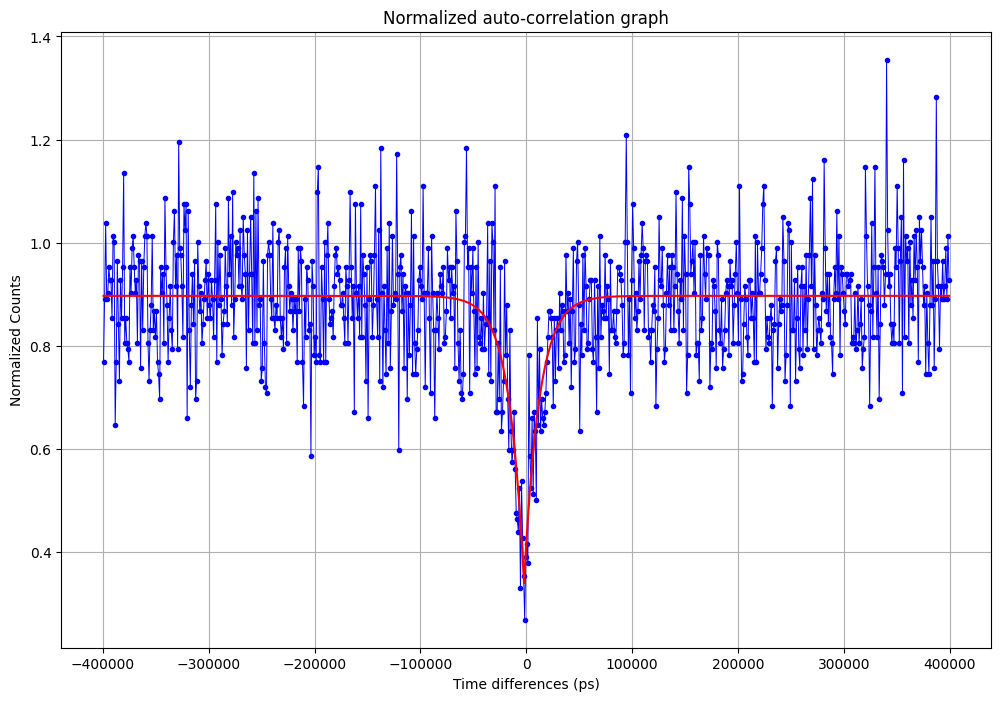

Fitted parameters: t₀ = -1499.95 ± 8343.21 ps
Lifetime = 259.03 ± 23.08 ns
p = 0.81 ± 0.01
g²(τ = t₀) = 0.766 ± 0.012


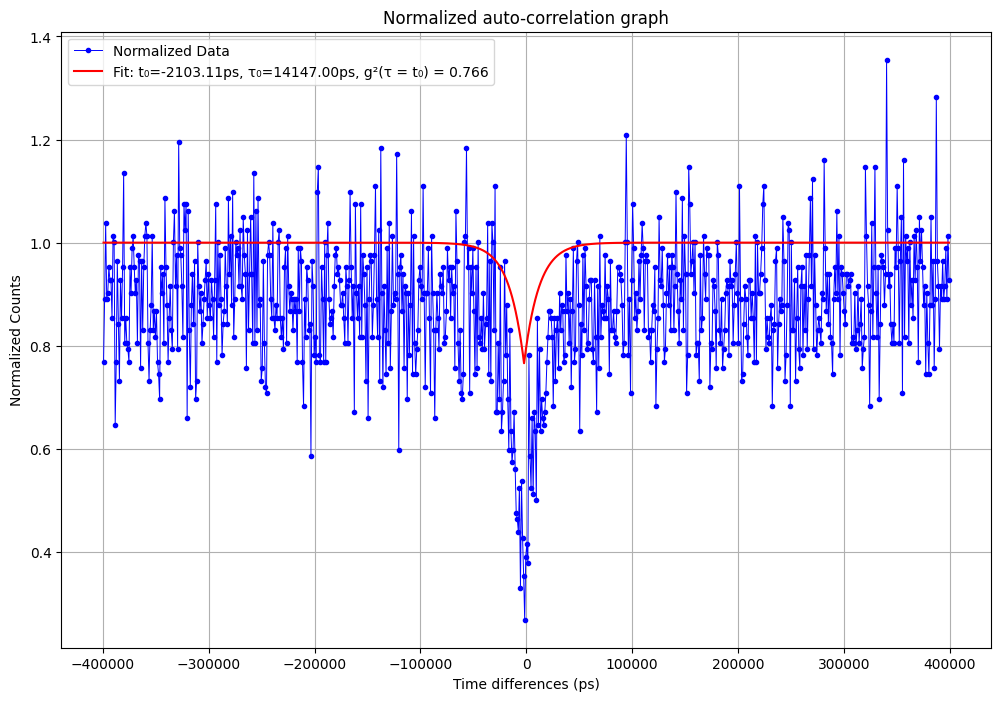

In [239]:
# Normalize counts= np.count_nonzero(times_channel_0)
counts_ch1 = np.count_nonzero(times_channel_0)
counts_ch2 = np.count_nonzero(times_channel_1)
capture_duration = np.sum(intervals_ON)
counts_normalized = (counts  * capture_duration)/(bin_width * counts_ch1 * counts_ch2) 

# Plot the normalized data and the fitted curve (noblinking)
t_0, tau_0, a, b = fit_noblinking(bin_centers, counts_normalized)
plot_fit_noblinking(bin_centers, counts_normalized, t_0, tau_0, a, b, width=12, height=8)

# Plot the normalized data and the fitted curve (blinking)
t_0_blinking, tau_0_blinking, p = fit_blinking(bin_centers, counts_normalized)
plot_fit_blinking(bin_centers, counts_normalized, t_0, tau_0, p, width=12, height=8)